# Parallel Text Style Transfer
In this tutorial we are going to implement an encoder-decoder model based on recurrent neural networks to perform text style transfer. You will implement it step-by-step.
## Prerequisites
We first need to select a device where we run our model and seed the libraries for reproducibility.

In [36]:
import numpy as np
import torch

# we will use CUDA if it is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

cuda


## Data loading
In the first step we are going to download and prepare the parallel dataset for text style. We will use the Shakespeare dataset with modern and "Shakespearean" sentences. Therefore, download it from https://github.com/harsh19/Shakespearizing-Modern-English/tree/master/data into ./data.

Afterwards, we load the dataset, clean it and remove long source sentences. We choose modern sentences as our source style and the original "Shakespearean" sentences as the target style.

In [37]:
!git clone  https://github.com/harsh19/Shakespearizing-Modern-English.git


fatal: destination path 'Shakespearizing-Modern-English' already exists and is not an empty directory.


In [38]:
def load_sent(path):
    sents = []
    with open(path) as f:
        for line in f:
            sents.append(line.split())
    return sents


def clean_lines(lines):
    cleaned = []
    for line in lines:
        # convert to lower case
        line = [word.lower() for word in line]
        cleaned.append(line)
    return cleaned


def filter_lines(lines, max_len):
    filtered_lines = []
    for line in lines:
        if len(line[0]) <= max_len:
            filtered_lines.append(line)
    return filtered_lines

MAX_LEN = 20

# download data from https://github.com/harsh19/Shakespearizing-Modern-English/tree/master/data into ./data
train_modern_sents = clean_lines(load_sent('data/train.modern.nltktok'))
train_original_sents = clean_lines(load_sent('data/train.original.nltktok'))
train_sents = filter_lines(zip(train_modern_sents, train_original_sents), MAX_LEN)
valid_modern_sents = clean_lines(load_sent('data/valid.modern.nltktok'))
valid_original_sents = clean_lines(load_sent('data/valid.original.nltktok'))
valid_sents = filter_lines(zip(valid_modern_sents, valid_original_sents), MAX_LEN)
test_modern_sents = clean_lines(load_sent('data/test.modern.nltktok'))
test_original_sents = clean_lines(load_sent('data/test.original.nltktok'))
test_sents = filter_lines(zip(test_modern_sents, test_original_sents), MAX_LEN)

## Vocabulary
In this step, we are building our vocabulary.

In [39]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {k: j for j, k in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = {}  # init the freq dict
        idx = 4  # index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        for sentence in sentence_list:
            for word in sentence:
                if word not in frequencies.keys():
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

        # limit vocab by removing low freq words
        frequencies = {k: v for k, v in frequencies.items() if v > self.freq_threshold}

        # create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1

    def numericalize(self, text, remove_unk=False):
        numericalized_text = []
        for token in text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            elif not remove_unk:  # out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])
        return numericalized_text


FREQ_THRESHOLD = 5
modern_vocab = Vocabulary(FREQ_THRESHOLD)
modern_vocab.build_vocabulary(train_modern_sents)
original_vocab = Vocabulary(FREQ_THRESHOLD)
original_vocab.build_vocabulary(train_original_sents)

## Numericalize

In [40]:
def numericalize(sentences, remove_unk=False):
    numericalized_sentences = []
    for sent in sentences:
        numericalized_sentences.append((modern_vocab.numericalize(sent[0],remove_unk), original_vocab.numericalize(sent[1],remove_unk)))
    return numericalized_sentences


PAD_IDX = modern_vocab.stoi['<PAD>']
numericalized_train = numericalize(train_sents)
numericalized_valid = numericalize(valid_sents)
numericalized_test = numericalize(test_sents)

## Dataset
In this part, you are asked to write a Dataset class that holds the parallel dataset, the source and the target vocabulary. It should return the numericalized version of each sentence including start and end of sequence tokens. Think about whether you need these for source as well as target sentences.

In [41]:
from torch.utils.data import Dataset

class StyleTransferDataset(Dataset):
    def __init__(self, data, source_vocab, target_vocab):
        #implement
        self.data = data
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        for sentences in self.data:
            sentences[0].insert(0,modern_vocab.stoi['<SOS>'])
            sentences[0].append(modern_vocab.stoi['<EOS>'])
            sentences[1].insert(0,modern_vocab.stoi['<SOS>'])
            sentences[1].append(modern_vocab.stoi['<EOS>'])

    def __len__(self):
        #implement
        return len(self.data)

    def __getitem__(self, index):
        #implement
        return self.data[index][0] , self.data[index][1]
    


train_dataset = StyleTransferDataset(numericalized_train, modern_vocab, original_vocab)
valid_dataset = StyleTransferDataset(numericalized_valid, modern_vocab, original_vocab)
test_dataset = StyleTransferDataset(numericalized_test, modern_vocab, original_vocab)

## DataLoader
Now, use a DataLoader to load the data in batches. The collate function should pad the sequences with the batch dimension as the first dimension.

In [42]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
train_batch_size = 64
valid_batch_size = 1


class MyCollate:
    def __init__(self, pad_idx):
        # implement
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # implement
        data_batch, label_batch = [torch.Tensor(data).type(torch.long) for data , label in batch],[torch.Tensor(label).type(torch.long) for data , label in batch]
        x_lens = [len(x) for x in data_batch]
        y_lens = [len(y) for y in label_batch]
        data_batch = pad_sequence(data_batch, batch_first=True, padding_value=self.pad_idx)
        label_batch = pad_sequence(label_batch, batch_first=True,
                             padding_value=self.pad_idx)
        data_batch = data_batch,x_lens
        label_batch = label_batch,y_lens
        return [data_batch, label_batch]


train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                          collate_fn=MyCollate(pad_idx=PAD_IDX))
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False,
                          collate_fn=MyCollate(pad_idx=PAD_IDX))
test_loader = DataLoader(test_dataset, batch_size=valid_batch_size, shuffle=False,
                         collate_fn=MyCollate(pad_idx=PAD_IDX))


# Model
## Encoder-Decoder
The encoder-decoder class has references to the encoder, the decoder, the embeddings and the generator.

In [43]:
import torch.nn as nn

class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator

    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)

    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)

    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

## Generator
The generator is needed to project from the hidden representation to our target vocab.

In [44]:
import torch.nn.functional as F

class Generator(nn.Module):
    """Define standard linear + softmax generation step."""

    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder
The encoder encodes a given input sequence into list of hidden states of the same length. Here, we use Gated Recurrent Units (GRUs). They are very similar to Long Short-Term Memory (LSTM) with a forget gate, have fewer parameters and lack an output gate.

In [45]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""

    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=True, dropout=dropout)

    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

## Decoder
The decoder is conditioned on the output from the encoder. Its initial hidden state is initialized from the encoder's final hidden vector.

For training, we will use teacher forcing. The decoder gets the "true" target words as input. You can read this post for details: https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c

In inference mode, the decoder will see its own output as input.

In [46]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""

    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
        
        self.rnn = nn.GRU(emb_size + 2 * hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)

        # to initialize from the final encoder state
        self.bridge = nn.Linear(2 * hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2 * hidden_size + emb_size,
                                          hidden_size, bias=False)

    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output

    def forward(self, trg_embed, encoder_hidden, encoder_final,
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""

        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)

        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []

        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            
            #implement
            out, hidden, pre_output = self.forward_step(
            prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(out)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))

##Teacher Forcing
Advantage -  During training decoder receives the correct outpur from the training set as the previously decoded result to predict the next output. However, during inference decoder receives the previously decoded result to predict the next output. Teacher forcing improves the training process.
\
Disadvantage - suffers from Exposure Bias as the model has to feed its prediction back to itself which causes poor model performance and instability.

## Attention
In this step, you are asked to implement the additive attention mechanism introduced by Bahdanau et al. in this paper https://arxiv.org/pdf/1409.0473.pdf. You can also read this blogpost https://lilianweng.github.io/posts/2018-06-24-attention/ for further explanation

In [47]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
## todo
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()

        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        self.alphas = None

    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        query = self.query_layer(query)
        
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        context = torch.bmm(alphas, value)
        
        return context, alphas

## Creating the model
We will use this auxilary function in order to create our model

In [48]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.to(DEVICE)

## Loss

In [49]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

## Auxiliary batch class
This class holds additional information about our sequences, like lenghts, masking for padding that needs to be added before we feed our batches into the network.

In [50]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """

    def __init__(self, src, trg, pad_index):

        src, src_lengths = src

        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)

        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()

        self.src = self.src.to(DEVICE)
        self.src_mask = self.src_mask.to(DEVICE)

        if trg is not None:
            self.trg = self.trg.to(DEVICE)
            self.trg_y = self.trg_y.to(DEVICE)
            self.trg_mask = self.trg_mask.to(DEVICE)

## Auxiliary functions
Here, we implement two additional functions to lookup words in the vocab and create Batch objects from the batch class

In [51]:
def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]
    return [str(t) for t in x]


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    # print(batch[0])
    return Batch(batch[0], batch[1], pad_idx)

## Greedy decode
We will use this function to generate the output in inference mode.

In [52]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
                encoder_hidden, encoder_final, src_mask,
                prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())

    output = np.array(output)

    # cut off everything starting from
    # (only when eos_index provided)
    if eos_index is not None:
        #implement
        f_eos = np.where(output==eos_index)[0]
        if len(f_eos) > 0:
            output = output[:f_eos[0]]  
    
    
    return output, np.concatenate(attention_scores, axis=1)


## Auxiliary function to print some examples

In [53]:
def print_examples(example_iter, model, n=2, max_len=100,
                   sos_index=1,
                   src_eos_index=None,
                   trg_eos_index=None,
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()

    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi['<EOS>']
        trg_sos_index = trg_vocab.stoi['<SOS>']
        trg_eos_index = trg_vocab.stoi['<EOS>']
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None

    for i, batch in enumerate(example_iter):

        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove  (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg

        result, _ = greedy_decode(
            model, batch.src, batch.src_mask, batch.src_lengths,
            max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i + 1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()

        count += 1
        if count == n:
            break

## Run one epoch

In [54]:
import time, math

def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
       
        out, _, pre_output = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask, batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens

        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                  (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

## Train the model

In [55]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    model.to(DEVICE)
    
    # implement
    
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_IDX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    train_perplexities = []
    dev_perplexities = []

    for epoch in range(num_epochs):
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_IDX, b) for b in train_loader),
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        train_perplexities.append(train_perplexity)
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_IDX, x) for x in valid_loader),
                           model, n=3, src_vocab=modern_vocab, trg_vocab=original_vocab)

            dev_perplexity = run_epoch((rebatch(PAD_IDX, b) for b in valid_loader),
                                       model,
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)

    return train_perplexities, dev_perplexities


## Run and evaluate the model

/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0
Epoch Step: 100 Loss: 48.825207 Tokens per Sec: 14811.776733
Epoch Step: 200 Loss: 52.991856 Tokens per Sec: 14548.230379

Example #1
Src :  <SOS> now , you lie there on the <UNK> .
Trg :  lie thou there ( <UNK> down a letter ) , for here comes the <UNK> that must be caught with <UNK> .
Pred:  o , you are <UNK> .

Example #2
Src :  <SOS> she said if she were <UNK> in someone , it would be someone who looked like me .
Trg :  <UNK> once told me she did <UNK> me , and i have heard herself come thus near , that , should she fancy , it should be one of my complexion .
Pred:  if i am <UNK> , i am <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK> <UNK> , and <UNK

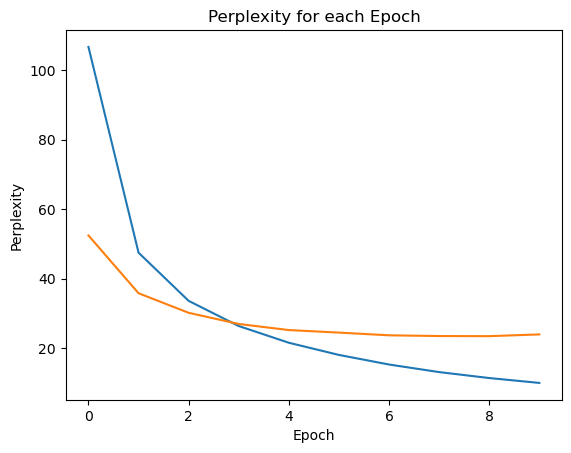

In [56]:
model = make_model(len(modern_vocab), len(original_vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
train_perplexities, dev_perplexities = train(model, num_epochs=10, print_every=100)

import matplotlib.pyplot as plt

def plot_perplexity(perplexities):
    #implement
    plt.title("Perplexity for each Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

plot_perplexity(train_perplexities)
plot_perplexity(dev_perplexities)

def test():
    style_transferred_sent = []
    alphas = []  # save the last attention scores
    for batch in test_loader:
        batch = rebatch(PAD_IDX, batch)
        pred, attention = greedy_decode(
            model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
            sos_index=modern_vocab.stoi['<SOS>'],
            eos_index=original_vocab.stoi['<EOS>'])
        style_transferred_sent.append(pred)
        alphas.append(attention)
    return style_transferred_sent

style_transferred_sent = test()
style_transferred_sent = [lookup_words(x, original_vocab) for x in style_transferred_sent]
style_transferred_sent = [" ".join(x) for x in style_transferred_sent]

## Training Model without unknown tokens

Epoch 0
Epoch Step: 100 Loss: 48.483326 Tokens per Sec: 15755.261656
Epoch Step: 200 Loss: 43.292500 Tokens per Sec: 14471.206488

Example #1
Src :  <SOS> now , you lie there on the .
Trg :  lie thou there ( down a letter ) , for here comes the that must be caught with .
Pred:  why , you , you are the .

Example #2
Src :  <SOS> she said if she were in someone , it would be someone who looked like me .
Trg :  once told me she did me , and i have heard herself come thus near , that , should she fancy , it should be one of my complexion .
Pred:  he is it is it is it is it , i will not be .

Example #3
Src :  <SOS> besides , she me more than the other servants .
Trg :  besides , she me with a more respect than else that follows her .
Pred:  why , i am me , i will not the .

Validation perplexity: 58.687620
Epoch 1
Epoch Step: 100 Loss: 41.626564 Tokens per Sec: 14736.757943
Epoch Step: 200 Loss: 37.815865 Tokens per Sec: 14677.418852

Example #1
Src :  <SOS> now , you lie there on the .
Tr

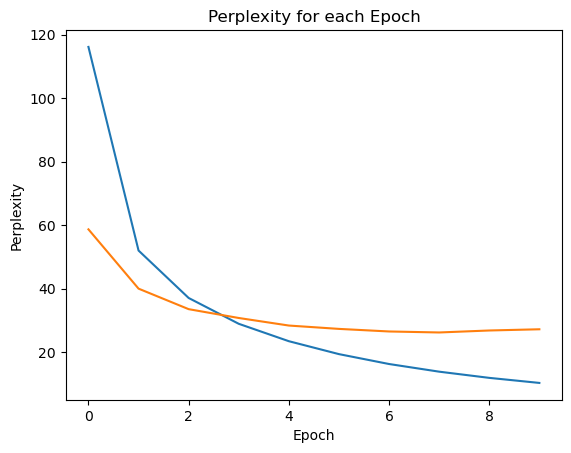

In [57]:


numericalized_train = numericalize(train_sents,remove_unk=True)
numericalized_valid = numericalize(valid_sents,remove_unk=True)
numericalized_test = numericalize(test_sents,remove_unk=True)

train_dataset = StyleTransferDataset(numericalized_train, modern_vocab, original_vocab)
valid_dataset = StyleTransferDataset(numericalized_valid, modern_vocab, original_vocab)
test_dataset = StyleTransferDataset(numericalized_test, modern_vocab, original_vocab)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                          collate_fn=MyCollate(pad_idx=PAD_IDX))
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False,
                          collate_fn=MyCollate(pad_idx=PAD_IDX))
test_loader = DataLoader(test_dataset, batch_size=valid_batch_size, shuffle=False,
                         collate_fn=MyCollate(pad_idx=PAD_IDX))

model = make_model(len(modern_vocab), len(original_vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
train_perplexities, dev_perplexities = train(model, num_epochs=10, print_every=100)

plot_perplexity(train_perplexities)
plot_perplexity(dev_perplexities)

def test():
    style_transferred_sent = []
    alphas = []  # save the last attention scores
    for batch in test_loader:
        batch = rebatch(PAD_IDX, batch)
        pred, attention = greedy_decode(
            model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
            sos_index=modern_vocab.stoi['<SOS>'],
            eos_index=original_vocab.stoi['<EOS>'])
        style_transferred_sent.append(pred)
        alphas.append(attention)
    return style_transferred_sent

style_transferred_sent = test()
style_transferred_sent = [lookup_words(x, original_vocab) for x in style_transferred_sent]
style_transferred_sent = [" ".join(x) for x in style_transferred_sent]

## Save output


In [58]:
#implement save to file 
print(len(style_transferred_sent))
with open('style_transferred_sent.txt', 'w') as f:
    for line in style_transferred_sent:
        f.write(line)
        f.write('\n')

1350


## Evaluate the output using BLEU

In [59]:
# !pip install sacrebleu

In [60]:
from sacrebleu.metrics import BLEU

bleu = BLEU()

#BLEU metric 
temp = filter_lines(test_original_sents, MAX_LEN) # removing UNK tokens 

result = bleu.corpus_score(style_transferred_sent, temp)

print(result)

BLEU = 7.75 72.7/5.6/3.6/2.5 (BP = 1.000 ratio = 2.750 hyp_len = 11 ref_len = 4)


 LSTM-RNNs can perform better than encoder-decoder
architectures for style transfer because they are
able to capture long-term dependencies in the data.
This means that they can better capture the nuances
of the style being transferred, allowing for more
accurate and detailed style transfer. Additionally,
LSTM-RNNs are able to learn from the data in an
unsupervised manner, meaning that they can learn
from the data without the need for labeled data.
This makes them more efficient and effective than
encoder-decoder architectures, which require labeled
data for training.